# Journey to Springfield


План по улучшению результата:
1) dropout настроить - p=0.2 вроде норм - мемшался(acc стартовала с 0.6 vs 0.8 без него) - убрал
2) requires_grad=False не везде поставить - оставил два последних conv2d
3) посмотреть как данные делятся - есть классы с очень малым кол-вом примеров <100 => см 5)
4) добавить random horizontalflip - DONE
5) weighted loss - если мало экземпляров, то ошибка 'дороже', иначе 'дешевая'
6) VGG16 вместо VGG13: vgg13 - 80% без 5) и 93% c 5) vs 97% у vgg16
7) кросс-валидация - DONE
8) докопировать картинок, которых < 20 - DONE
9) увеличить rescale_size до 256 и выше?
10) отбор модели по F1 а не по loss и acc - DONE
11) попробовать resnet

F1 score 0.86 - выполнены пункты 1 2 4

F1 score 0.904 - выполнены пункты 2 3 5 7 8

F1 score 0.958 - выполнены пункты выше и 6, взята модель loss 0.73 acc 0.97

F1 score 0.974 - выполнены пункты выше и 9, взята модель loss 0.84 acc 0.98

Base pipeline:
1) загрузка данных
2) обработка данных
3) загрузка модели
4) обучение модели
5) предсказание на тесте для отправки

In [1]:
from tqdm import tqdm
from datetime import datetime

import os
import sys
import time
import pickle
import json
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score

from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models, transforms
from torchsummary import summary, summary_string

In [2]:
import sys
import time

class ProgressBar():
    def __init__(self, total, status='', count=0):
        self.total = total
        self.count = count
        self.status = status
        self.str = ''
        
    def update(self, step=1):
        self.count += step
        bar_len = 60
        filled_len = int(round(bar_len * self.count / float(self.total)))
        filled_len = min(bar_len, filled_len)
    
        percents = round(100.0 * self.count / float(self.total), 1)
        bar = '=' * filled_len + '-' * (bar_len - filled_len)
    
        self.str = '%s[%s] %s%s [%s/%s]\r' % (self.status, bar, percents, '%', self.count, self.total)
        sys.stdout.write(self.str)
        sys.stdout.flush()    

    def finish(self):
        print('\n')
        

## загрузка и обработка данных

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dir = './data/journey-springfield'
train_val_path = Path(dir+'/train/simpsons_dataset')
test_path = Path(dir+'/testset/testset')

In [4]:
rescale_size = 256
#resized_crop = 250

In [5]:
class CustomDataset(Dataset):
    def __init__(self, files, labels, transform):
        super().__init__()
        self.files = files
        self.type = type
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = self.get_image(index)
        img = self.transform(img)
        if self.labels != None:
            return img, self.labels[index]
        else:
            return img, -1

    def get_image(self, index):
        img = Image.open(self.files[index])
        img.load()
        img = img.resize((rescale_size, rescale_size))
        return np.array(img)
        
        

In [6]:
def count_classes(files: list):
    files = [path.parent.name for path in files]
    unic = set(files)
    total = 0
    for u in unic:
        print(u, files.count(u))
        total += files.count(u)
    print('Total', total, '\n'+'-'*30+'\n')

In [7]:
train_val_files = list(train_val_path.rglob('*.jpg'))

train_val_labels = [path.parent.name for path in train_val_files]
label_encoder = LabelEncoder()
label_encoder.fit(train_val_labels)
train_val_labels_id = torch.tensor(label_encoder.transform(train_val_labels))

test_files = list(test_path.rglob('*.jpg'))
#train_files, val_files, train_labels_id, val_labels_id = train_test_split(train_val_files, train_val_labels_id, test_size=0.2)

In [8]:
count_classes(train_val_files)

edna_krabappel 457
sideshow_bob 877
maggie_simpson 128
principal_skinner 1194
cletus_spuckler 47
snake_jailbird 55
chief_wiggum 986
troy_mcclure 24
rainier_wolfcastle 45
lionel_hutz 15
agnes_skinner 42
sideshow_mel 40
lenny_leonard 310
krusty_the_clown 1206
milhouse_van_houten 1079
kent_brockman 498
miss_hoover 17
ned_flanders 1454
professor_john_frink 65
comic_book_guy 469
barney_gumble 106
apu_nahasapeemapetilon 623
fat_tony 27
patty_bouvier 72
bart_simpson 1342
waylon_smithers 181
otto_mann 32
gil 27
groundskeeper_willie 121
selma_bouvier 103
carl_carlson 98
charles_montgomery_burns 1193
abraham_grampa_simpson 913
lisa_simpson 1354
moe_szyslak 1452
marge_simpson 1291
mayor_quimby 246
disco_stu 24
ralph_wiggum 89
nelson_muntz 358
martin_prince 71
homer_simpson 2246
Total 20977 
------------------------------



In [9]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomResizedCrop(size=(resized_crop, resized_crop), antialias=True),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    #transforms.CenterCrop(size=(resized_crop, resized_crop))
])

train_val_dataset = CustomDataset(files=train_val_files, labels=train_val_labels_id, transform=val_transform)
test_dataset = CustomDataset(files=test_files, labels=None, transform=val_transform)

In [10]:
len(test_dataset)

992

In [11]:
def show_images(dataset, indexes, mean, std):
    plt.figure(figsize=(15, 4*(len(indexes)//3+1)))
    for n, idx in enumerate(indexes):
        img, label = dataset[idx]
        img = img.numpy().transpose((1,2,0))
        img = std*img+mean
        img = img.clip(0, 1)
        label = " ".join(map(lambda x: x.capitalize(),\
                label_encoder.inverse_transform([label])[0].split('_')))
        ax = plt.subplot(len(indexes)//3+1,3, n+1)
        ax.imshow(img)
        ax.set_title(label)
        ax.grid(False)
    plt.show()

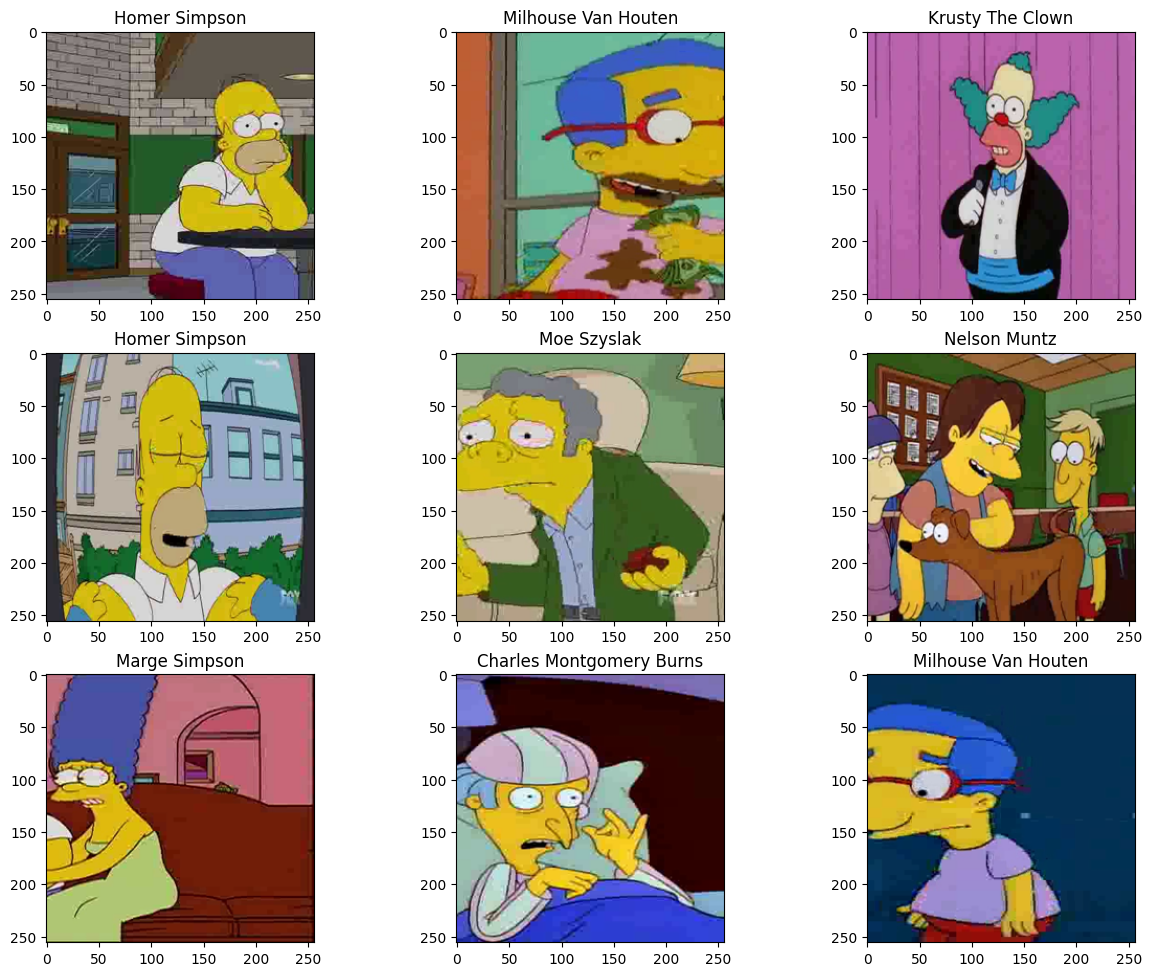

In [12]:
indexes = np.random.randint(len(train_val_dataset), size=9)
show_images(train_val_dataset, indexes, mean, std)

## model helpers

In [13]:
def train_epoch(train_dataloader ,model, criterion, optimizer, sheduler):
    pbar = ProgressBar(len(train_dataloader), 'train')
    model.train()
    
    total_examples = 0
    train_loss = 0
    epoch_correct = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_examples += y.size(0)
        train_loss += loss.item()*y.size(0)
        epoch_correct += torch.sum(y.data==torch.argmax(output, 1))
        pbar.update()
    pbar.finish()
    sheduler.step()
    train_loss /= total_examples
    train_accuracy = epoch_correct.item() / total_examples
    return train_loss, train_accuracy
        

In [14]:
def eval_epoch(val_dataloader, model):
    pbar = ProgressBar(len(val_dataloader), 'val')
    model.eval()
    
    total_examples = 0
    val_loss = 0
    epoch_correct = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
    
            total_examples += y.size(0)
            val_loss += loss.item()*y.size(0)
            epoch_correct += torch.sum(y.data==torch.argmax(output, 1))
            pbar.update()
    pbar.finish()
    val_loss /= total_examples
    val_accuracy = epoch_correct.item() / total_examples
    return val_loss, val_accuracy

In [61]:
k_folds = 5
def train(history, train_val_dataset, epochs, model, criterion, optimizer, sheduler):
    kf = KFold(n_splits=k_folds, shuffle=True)
    f1_best = 0.0

    for epoch in range(epochs//k_folds+1):
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
            train_dataloader = DataLoader(train_val_dataset, batch_size=32,
                                         sampler=torch.utils.data.SubsetRandomSampler(train_idx))
            val_dataloader = DataLoader(train_val_dataset, batch_size=32,
                                       sampler=torch.utils.data.SubsetRandomSampler(val_idx))
            
            train_loss, train_acc = train_epoch(train_dataloader, model, criterion, optimizer, sheduler)
            val_loss, val_acc = eval_epoch(val_dataloader, model)

            probs = predict(train_val_dataset, model)
            preds = torch.argmax(probs, 1).to('cpu')
            f1 = f1_score(train_val_labels_id, preds, average='micro')
            if f1 > f1_best:
                f1_best = f1
                torch.save(model.state_dict(), f'./weights/ResNet50_F1:{f1:.4f}.pt')

            history.loc[len(history)] = [f'{len(history)+1}', f1, train_loss, train_acc, val_loss, val_acc]
            print(f'F1 score: {f1}')
            print(history.iloc[-1], '\n')

In [16]:
def predict(test_dataset, model):
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

    model.eval()
    probs = None
    with torch.no_grad():
        for x, _ in tqdm(test_dataloader):
            x = x.to(device)
            output = model(x)
            p = nn.functional.softmax(output, 1)
            if probs == None:
                probs = p
            else:            
                probs = torch.concatenate((probs, p), axis=0)
    return probs

## upload and train model

In [62]:
history_file = './history/journey-springfield/ResNet50_'+datetime.now().strftime("%y:%m:%d_%H:%M")+'.txt'
history = pd.DataFrame(columns=['Epoch', 'F1 score', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
model = torchvision.models.resnet50(weights='DEFAULT')

In [55]:
!nvidia-smi

Wed Jan 31 17:50:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8              N/A / ERR! |    326MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [67]:
model.fc = nn.Sequential(nn.Linear(2048, 42, bias = True))

for i, layer in enumerate(model.parameters()):
    layer.requires_grad = False
for layer in model.layer4.parameters():
    layer.requires_grad = True
for layer in model.fc.parameters():
    layer.requires_grad = True
model.to(device)

with open(history_file, 'a') as file:
    result, params_info = summary_string(model, (3, rescale_size, rescale_size))
    file.write(result)
    file.write(str(model))

In [68]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
summary(model.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

(tensor(23594090), tensor(15050794))

In [58]:
def count_loss_weight(labels_id):
    uniq, count = torch.unique(labels_id, return_counts=True)
    weight = torch.zeros(uniq.size(0))
    for u in uniq:
        weight[u] = (3*torch.max(count)-count[u])/torch.max(count)
    table = pd.DataFrame({'name': label_encoder.inverse_transform(uniq), 'count': count, 'weight': weight})
    #print(table)
    #mean = torch.mean(weight)
    #std = torch.std(weight)
    #weight = (weight-mean)/std
    return weight.to(device)


In [59]:
count_loss_weight(train_val_labels_id)

tensor([2.5935, 2.9813, 2.7226, 2.9528, 2.4025, 2.9564, 2.4688, 2.5610, 2.9791,
        2.7912, 2.9893, 2.7965, 2.9880, 2.9880, 2.9461, 2.0000, 2.7783, 2.4630,
        2.8620, 2.9933, 2.3972, 2.9430, 2.4252, 2.9684, 2.8905, 2.5196, 2.9924,
        2.3535, 2.3526, 2.8406, 2.9858, 2.9679, 2.4684, 2.9711, 2.9800, 2.9604,
        2.9541, 2.6095, 2.9822, 2.9755, 2.9893, 2.9194], device='cuda:0')

In [ ]:
criterion = nn.CrossEntropyLoss(weight=count_loss_weight(train_val_labels_id))
optimizer = optim.Adam([{'params': model.layer4.parameters(), 'lr': 1e-4},
                       {'params': model.fc.parameters()}], lr=1e-3)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

train(history, train_val_dataset, 60, model, criterion, optimizer, sheduler)

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:08<00:00,  3.48it/s]


F1 score: 0.9733994374791438
Epoch                1
F1 score      0.973399
train_loss    0.776797
train_acc     0.815804
val_loss       0.24232
val_acc       0.938275
Name: 0, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:08<00:00,  3.48it/s]


F1 score: 0.9939457501072604
Epoch                2
F1 score      0.993946
train_loss    0.141473
train_acc     0.965378
val_loss      0.061179
val_acc       0.985701
Name: 1, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.50it/s]


F1 score: 0.9974257520141107
Epoch                3
F1 score      0.997426
train_loss    0.043728
train_acc      0.98993
val_loss       0.02241
val_acc       0.994756
Name: 2, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:08<00:00,  3.48it/s]


F1 score: 0.9994756161510225
Epoch                4
F1 score      0.999476
train_loss    0.019055
train_acc     0.994995
val_loss      0.004209
val_acc       0.999523
Name: 3, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.49it/s]


F1 score: 0.9989512323020451
Epoch                5
F1 score      0.998951
train_loss    0.016264
train_acc     0.995948
val_loss      0.004545
val_acc        0.99857
Name: 4, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:09<00:00,  3.46it/s]


F1 score: 0.998093149640082
Epoch                6
F1 score      0.998093
train_loss    0.017961
train_acc     0.994696
val_loss      0.011746
val_acc       0.995949
Name: 5, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.49it/s]


F1 score: 0.9995232874100205
Epoch                7
F1 score      0.999523
train_loss    0.013945
train_acc     0.995709
val_loss      0.004199
val_acc       0.999047
Name: 6, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.51it/s]


F1 score: 0.9992849311150307
Epoch                8
F1 score      0.999285
train_loss    0.011949
train_acc     0.996663
val_loss      0.004102
val_acc        0.99857
Name: 7, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.50it/s]


F1 score: 0.9937550650712685
Epoch                9
F1 score      0.993755
train_loss    0.014343
train_acc      0.99571
val_loss      0.031621
val_acc       0.994041
Name: 8, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:06<00:00,  3.51it/s]


F1 score: 0.9994279448920246
Epoch               10
F1 score      0.999428
train_loss    0.014947
train_acc     0.996246
val_loss        0.0024
val_acc       0.999523
Name: 9, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.51it/s]


F1 score: 0.9995709586690185
Epoch               11
F1 score      0.999571
train_loss    0.010017
train_acc      0.99708
val_loss       0.00292
val_acc       0.999285
Name: 10, dtype: object 

train[============================================================] 100.0% [525/525]

val[============================================================] 100.0% [132/132]



100%|█████████████████████████████████████████| 656/656 [03:07<00:00,  3.50it/s]


F1 score: 0.9987128760070554
Epoch               12
F1 score      0.998713
train_loss     0.01072
train_acc     0.996603
val_loss       0.00511
val_acc        0.99857
Name: 11, dtype: object 



In [71]:
with open(history_file, 'a') as file:
    file.write('\n')
    file.write(history.to_string(index=False))

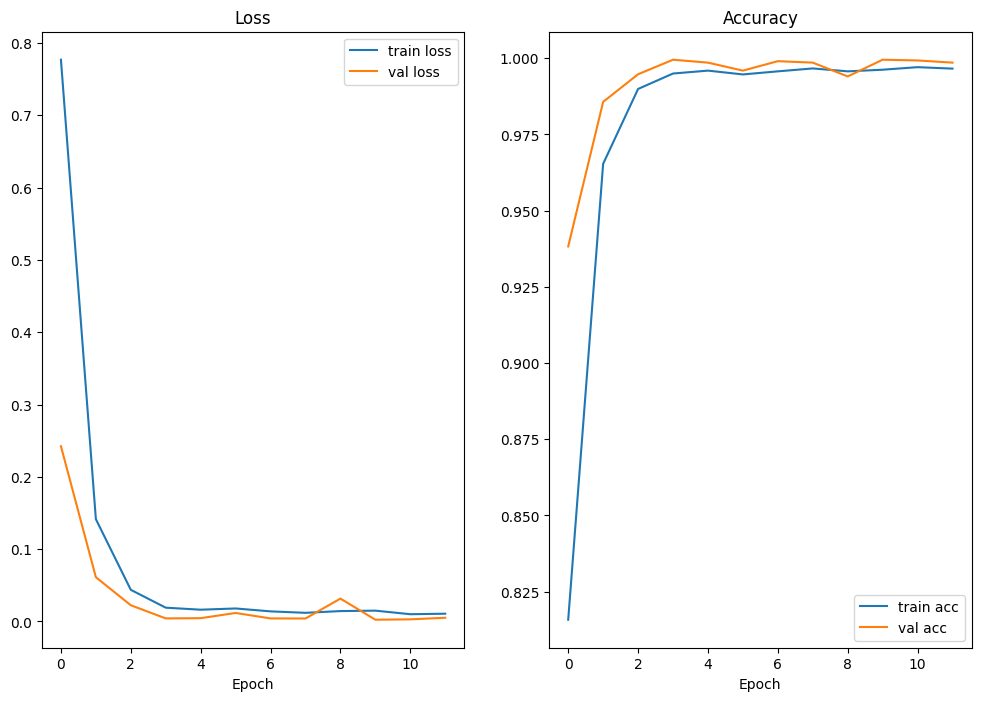

In [72]:
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(range(len(history)), history['train_loss'], label='train loss')
ax1.plot(range(len(history)), history['val_loss'], label='val loss')
ax1.set_xlabel('Epoch')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(range(len(history)), history['train_acc'], label='train acc')
ax2.plot(range(len(history)), history['val_acc'], label='val acc')
ax2.set_xlabel('Epoch')
ax2.set_title('Accuracy')
ax2.legend()

plt.savefig(history_file + '.png')
plt.show()

# Look at misstakes

In [73]:
weight_file = './weights/ResNet50_F1:0.9996.pt'
model.load_state_dict(torch.load(weight_file))

<All keys matched successfully>

In [74]:
probs = predict(train_val_dataset, model)

100%|█████████████████████████████████████████| 656/656 [04:30<00:00,  2.43it/s]


In [75]:
def count_incorrect(labels, preds):
    unic = torch.unique(labels)
    count = {'name': [], 'total': [], 'incorrect': []}
    total = 0
    for u in tqdm(unic):
        count['name'].append(" ".join(map(lambda x: x.capitalize(),\
                label_encoder.inverse_transform([u])[0].split('_'))))
        count['total'].append(torch.sum(labels==u).item())
        incorrect = torch.tensor([(labels[i]==u and labels[i]!=preds[i]) for i in range(len(labels))])
        count['incorrect'].append(torch.sum(incorrect).item())
    count['name'].append("Total")
    count['total'].append(labels.size(0))
    incorrect = torch.tensor([labels[i]!=preds[i] for i in range(len(labels))])
    count['incorrect'].append(torch.sum(incorrect).item())
    return count

In [76]:
preds = torch.argmax(probs, 1)
indexes = torch.nonzero(preds != train_val_labels_id.to('cuda'))
indexes = torch.flatten(indexes).to('cpu').numpy()
#show_images(all_dataset, indexes, mean, std)

In [77]:
count = pd.DataFrame(count_incorrect(train_val_labels_id, preds))
count

100%|███████████████████████████████████████████| 42/42 [00:15<00:00,  2.68it/s]


,name,total,incorrect
0,Abraham Grampa Simpson,913,0
1,Agnes Skinner,42,0
2,Apu Nahasapeemapetilon,623,0
3,Barney Gumble,106,2
4,Bart Simpson,1342,0
5,Carl Carlson,98,0
6,Charles Montgomery Burns,1193,1
7,Chief Wiggum,986,1
8,Cletus Spuckler,47,0
9,Comic Book Guy,469,1


In [78]:
count['incorrect'][42]/count['total'][42]

0.0004290413309815512

In [79]:
f1_score(train_val_labels_id, preds.to('cpu'), average='micro')

0.9995709586690185

# Submit

In [80]:
probs = predict(test_dataset, model)

100%|███████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


In [81]:
preds = torch.argmax(probs, 1).to('cpu')
preds = label_encoder.inverse_transform(preds)
test_filenames = [path.name for path in test_dataset.files]


In [86]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.to_csv('./data/journey-springfield/sixth.csv', index=False)